## Esto está pendiente para cuando pase el eclipe!!

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
datos = np.genfromtxt('datos.csv', delimiter=',')

In [10]:
datos

array([[   nan,    15.],
       [   nan,    15.],
       [   nan,    15.],
       [   nan,    15.],
       [   nan,    26.],
       [   nan,   343.],
       [   nan,  2159.],
       [   nan,  1549.],
       [   nan,  1627.],
       [   nan,  1544.],
       [   nan,  1493.],
       [   nan,  1587.],
       [   nan,  1593.],
       [   nan,   642.],
       [   nan,   631.],
       [   nan,   598.],
       [   nan,   560.],
       [   nan,   550.],
       [   nan,   547.],
       [   nan,   552.],
       [   nan,   496.],
       [   nan,   496.],
       [   nan,  1230.],
       [   nan,  1569.],
       [   nan,  1632.],
       [   nan,  1537.]])

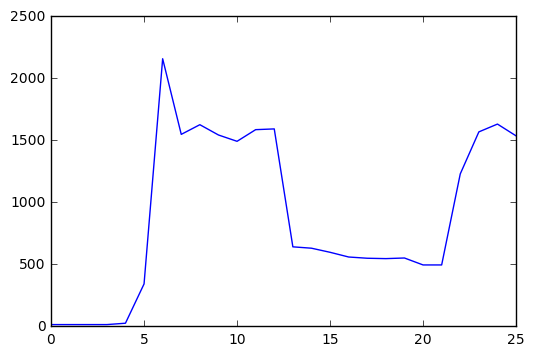

In [11]:
plt.plot(datos[:,1])